# read datas

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

import json
import numpy as np
import pandas as pd

with open('./tmp/typeid.json') as f:
    typeid = json.load(f)
with open('./tmp/bw_result.json') as f:
    typebw = json.load(f)
rentdf = pd.read_csv('./tmp/170911_rentclear.csv')
envdf = pd.read_csv('./tmp/env_clear.csv')

In [4]:
for key, value in typeid.items():
    print(key, value, typebw[key])

101 Food 300
102 Supermarket 2100
201 Bus 900
202 MRT 4300
203 UBike 3500
204 Train 6900
205 Exam 1700
206 Charger 5400
207 Towing 6000
301 BookStore 2400
302 DepartmentStore 1200
303 Library 4800
304 Museum 4100
305 Theater 2200
401 Park 1600
402 Scenic 1300
403 Sport 1400
501 School 4000
502 Hospital 5800
503 Pharmacy 3500
504 Police 6900
505 FireStation 6900


In [5]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KDTree

from LatLonToTWD97 import LatLonToTWD97
c = LatLonToTWD97()

In [6]:
%%time
rentdata = list(map(c.convert,rentdf.loc[:,['lat','lng']].values))
col = '{}:{}'
kdtree = {}
tmpdf = pd.DataFrame()
for key, value in typeid.items():
    name = col.format(key,typeid[key])
    bw = int(typebw[key])
    data = list(map(c.convert,envdf[envdf.typeID==int(key)].loc[:,['lat','lng']].values))
    kdtree[key] = KDTree(data)
    kde = KernelDensity(bandwidth=bw)
    kde.fit(data)
    tmpdf[name] = kde.score_samples(rentdata)

CPU times: user 1min 4s, sys: 57.2 ms, total: 1min 4s
Wall time: 1min 4s


In [8]:
%%time
col = '{}:{}'
countdf = pd.DataFrame()
for key, value in typeid.items():
    name = col.format(key,typeid[key])
    bw = int(typebw[key])
    countdf[name] = kdtree[key].query_radius(rentdata,r=bw, count_only=True)

CPU times: user 1.12 s, sys: 2.02 ms, total: 1.12 s
Wall time: 1.14 s


In [9]:
#conpute avg cost of food
foodf = envdf[envdf.typeID==101]
foodf.index=foodf.ID

In [10]:
def foodavg(array):
    if len(array)>0:
        try:
            return np.nanmean(foodf.loc[array,'cost'].dropna())
        except:
            pass
    else:
        return 0

In [11]:
favg = list(map(foodavg,kdtree['101'].query_radius(rentdata,r=typebw['101'])))

In [12]:
favg = pd.DataFrame(favg).fillna(value=214)

In [13]:
tmpdf.head()

,101:Food,102:Supermarket,201:Bus,202:MRT,203:UBike,204:Train,205:Exam,206:Charger,207:Towing,301:BookStore,...,304:Museum,305:Theater,401:Park,402:Scenic,403:Sport,501:School,502:Hospital,503:Pharmacy,504:Police,505:FireStation
0,-20.690013,-21.150177,-21.197688,-22.016565,-22.078798,-23.818845,-20.763704,-21.756216,-21.739868,-21.057701,...,-21.344104,-35.143631,-19.832454,-19.526913,-20.361726,-21.793622,-21.625844,-23.361540,-21.906159,-21.819031
1,-29.418300,-21.889287,-22.285826,-22.832456,-22.543544,-24.738320,-22.244460,-22.183499,-21.850956,-21.961800,...,-21.739857,-41.770144,-20.666102,-21.221613,-21.728591,-22.215835,-22.034202,-24.561982,-22.298620,-22.241080
2,-20.076350,-21.296837,-21.731911,-21.742753,-21.986086,-23.519200,-20.897927,-21.616462,-21.792917,-21.111542,...,-21.251749,-32.216696,-20.373445,-20.070019,-20.628840,-21.686197,-21.466098,-22.801697,-21.756647,-21.676334
3,-18.322282,-21.146282,-21.160755,-21.730500,-21.913950,-23.389006,-20.689591,-21.574648,-21.643634,-20.955411,...,-21.215287,-32.858452,-19.895306,-19.265852,-20.328033,-21.655434,-21.489876,-22.908381,-21.741798,-21.630667
4,-21.883530,-24.074363,-30.514663,-24.571018,-22.389492,-21.093035,-22.398776,-22.229883,-21.559772,-22.419500,...,-22.287442,-33.924655,-22.219667,-23.843253,-21.268603,-22.364983,-22.166921,-25.454403,-22.267152,-22.194877


In [14]:
countdf.head()

,101:Food,102:Supermarket,201:Bus,202:MRT,203:UBike,204:Train,205:Exam,206:Charger,207:Towing,301:BookStore,...,304:Museum,305:Theater,401:Park,402:Scenic,403:Sport,501:School,502:Hospital,503:Pharmacy,504:Police,505:FireStation
0,4,8,63,2,11,0,10,5,1,4,...,3,0,20,31,20,56,6,2,12,7
1,0,2,10,1,9,0,0,5,1,0,...,3,0,5,1,1,44,4,0,8,4
2,12,6,25,2,11,0,11,6,1,4,...,3,0,10,4,11,59,7,2,16,9
3,159,6,72,3,13,0,12,6,1,4,...,4,0,13,35,18,62,7,2,11,8
4,8,0,0,0,8,2,1,2,0,0,...,1,0,1,0,7,29,3,0,9,4


In [15]:
import re
lar = re.compile(r'^\d')
typecountdf = pd.DataFrame()
for key in countdf.columns:
    name = lar.findall(key)[0]
    if name in typecountdf.columns:
        typecountdf[name] = typecountdf[name] + countdf[key]
    else:
        typecountdf[name] = countdf[key]

In [16]:
typecountdf.head()

,1,2,3,4,5
0,12,92,9,71,83
1,2,26,5,7,60
2,18,56,10,25,93
3,165,107,11,66,90
4,8,13,3,8,45


In [17]:
expdf = tmpdf.applymap(lambda x:np.exp(x))

In [18]:
expdf.head(3)

,101:Food,102:Supermarket,201:Bus,202:MRT,203:UBike,204:Train,205:Exam,206:Charger,207:Towing,301:BookStore,...,304:Museum,305:Theater,401:Park,402:Scenic,403:Sport,501:School,502:Hospital,503:Pharmacy,504:Police,505:FireStation
0,1.033811e-09,6.525216e-10,6.222444e-10,2.743641e-10,2.578102e-10,4.524882e-11,9.603686e-10,3.559553e-10,3.618224e-10,7.157424e-10,...,5.374936e-10,5.461537e-16,2.437108e-09,3.308031e-09,1.435538e-09,3.428863e-10,4.055227e-10,7.148453e-11,3.063911e-10,3.342836e-10
1,1.674150e-13,3.116042e-10,2.095988e-10,1.213362e-10,1.619806e-10,1.804197e-11,2.184508e-10,2.321821e-10,3.237802e-10,2.898086e-10,...,3.618262e-10,7.235309e-19,1.058829e-09,6.075340e-10,3.659256e-10,2.247944e-10,2.695675e-10,2.152121e-11,2.069341e-10,2.191906e-10
2,1.909643e-09,5.635096e-10,3.647129e-10,3.607798e-10,2.828551e-10,6.105781e-11,8.397414e-10,4.093453e-10,3.431280e-10,6.782253e-10,...,5.894984e-10,1.019687e-14,1.418813e-09,1.921770e-09,1.099028e-09,3.817722e-10,4.757647e-10,1.251263e-10,3.558020e-10,3.855563e-10


In [19]:
#df = rentdf[['pet', 'rent']].join(tmpdf)
#df = rentdf[['pet', 'rent']].join(expdf)
df = rentdf[['pet', 'rent']].join(countdf)
#df = rentdf[['pet', 'rent']].join(typecountdf)

In [20]:
df['foodcost'] = favg

In [21]:
yn = {'N':0,'Y':1}
df['pet'] = df.pet.map(lambda x: yn.get(x))

In [22]:
from sklearn.preprocessing import Normalizer

nml = Normalizer(norm='max')
X = nml.fit_transform(df)

In [23]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# sc.fit(X_train)
# X_train_std = sc.transform(X_train)
# X_test_std = sc.transform(X_test)
X = sc.fit_transform(df)

In [38]:
# 直接使用scikit-learn實作
from sklearn.cluster import KMeans
# n_init=10, 隨機做十次  自動找出SSE最小的那一次
# max_iter=300, 或是 tol=1e-04, 為中止條件
clus = 4

km = KMeans(n_clusters=clus, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)


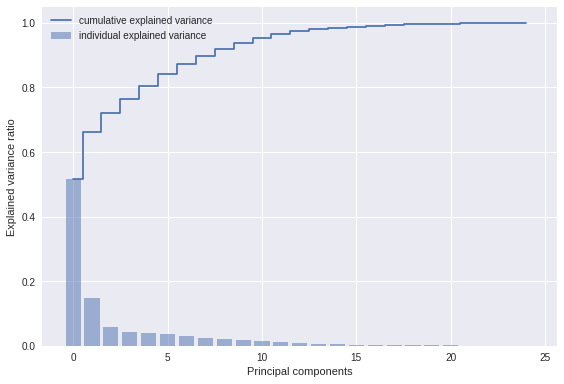

In [39]:
cov_mat = np.cov(X.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

#print('\nEigenvalues \n%s' % eigen_vals)

tot = sum(eigen_vals)
# 將特徵值排序  並計算百分比
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
# 加總
cum_var_exp = np.cumsum(var_exp)


length = len(X.T)
plt.bar(range(0, length), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(0, length), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

In [40]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low

eigen_pairs.sort(reverse=True)

# 取前兩名重要的向量  並排列整齊
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))

X_pca = X.dot(w)

In [41]:
y_km = km.fit_predict(X)

In [42]:
X_end = pd.DataFrame(X_pca,columns=['x','y'])
X_end['y_km'] = y_km

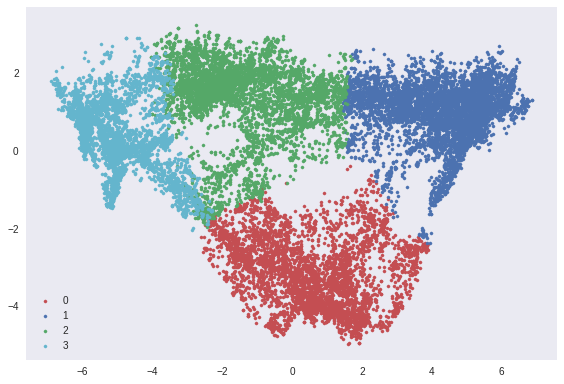

In [43]:
# 作圖

colors = ['r', 'b', 'g', 'c', 'm', 'y']

for l, c in zip(range(clus), colors):
    plt.scatter(X_end[y_km == l].x , 
                X_end[y_km == l].y, 
                c=c, label=l, s=10)


plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [44]:
resultdf = rentdf.join(df ,how='left', lsuffix='_left', rsuffix='_right')

In [45]:
resultdf['y'] = y_km

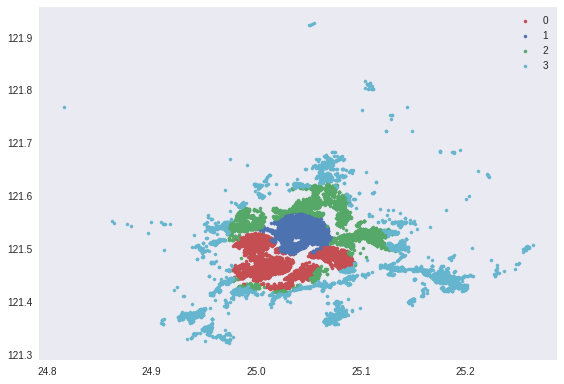

In [46]:
# 作圖

colors = ['r', 'b', 'g', 'c', 'm', 'y']

for l, c in zip(range(clus), colors):
    plt.scatter(resultdf[y_km == l].lat , 
                resultdf[y_km == l].lng, 
                c=c, label=l, s=10)


plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [47]:
resultdf.groupby('y').count().ID

y
0    4711
1    6460
2    5218
3    4548
Name: ID, dtype: int64

In [52]:
resultdf.groupby('y').describe()

101:Food  102:Supermarket      201:Bus      202:MRT    203:UBike  \
y                                                                              
0 count  4711.000000      4711.000000  4711.000000  4711.000000  4711.000000   
  mean     51.240501        19.118234   159.646784    15.956485    85.080238   
  std      45.970993         4.743285    91.109123     8.339481    17.719097   
  min       0.000000         7.000000     7.000000     4.000000    37.000000   
  25%      19.000000        16.000000    92.000000    10.000000    73.500000   
  50%      38.000000        19.000000   141.000000    12.000000    84.000000   
  75%      70.000000        21.000000   225.000000    20.000000    94.000000   
  max     271.000000        36.000000   460.000000    39.000000   138.000000   
1 count  6460.000000      6460.000000  6460.000000  6460.000000  6460.000000   
  mean    143.557585        26.354954   527.074149    48.150310   142.904180   
  std     114.776159         4.942228   106.570713     5.620653    16.292751   
  min       0.000000        14.000000   139.000000    29.000000    96.000000   
  25%      70.000000        23.000000   467.000000    45.000000   133.000000   
  50%     120.000000        26.000000   529.000000    49.000000   144.000000   
  75%     172.000000        30.000000   595.000000    53.000000   155.000000   
  max     738.000000        39.000000   867.000000    57.000000   179.000000   
2 count  5218.000000      5218.000000  5218.000000  5218.000000  5218.000000   
  mean     42.331928        13.016481   404.317363    18.451131    64.378689   
  std      49.366341         4.310602   176.414278     8.367517    24.441406   
  min       0.000000         1.000000     0.000000     3.000000    20.000000   
  25%       8.000000        10.000000   308.000000    11.000000    44.000000   
  50%      25.000000        13.000000   406.000000    16.000000    58.000000   
  75%      59.000000        16.000000   506.000000    25.000000    86.000000   
  max     323.000000        24.000000   935.000000    43.000000   137.000000   
3 count  4548.000000      4548.000000  4548.000000  4548.000000  4548.000000   
  mean     23.215919         5.989446    72.443052     3.404134    19.194371   
  std      32.591581         3.276480    85.693071     3.210975    11.791646   
  min       0.000000         0.000000     0.000000     0.000000     0.000000   
  25%       2.000000         4.000000    18.000000     1.000000    11.000000   
  50%       9.000000         6.000000    51.000000     2.000000    16.000000   
  75%      31.000000         8.000000    92.000000     6.000000    24.000000   
  max     223.000000        17.000000   512.000000    14.000000    64.000000   

           204:Train     205:Exam  206:Charger   207:Towing  301:BookStore  \
y                                                                            
0 count  4711.000000  4711.000000  4711.000000  4711.000000    4711.000000   
  mean      4.002123    29.702611    34.370197     6.554447       7.008491   
  std       1.184290     9.153635     5.505534     1.701116       5.457725   
  min       1.000000     6.000000    19.000000     1.000000       0.000000   
  25%       3.000000    23.000000    31.000000     6.000000       4.000000   
  50%       4.000000    29.000000    35.000000     7.000000       5.000000   
  75%       5.000000    35.000000    38.000000     8.000000       8.000000   
  max       6.000000    63.000000    47.000000     8.000000      36.000000   
1 count  6460.000000  6460.000000  6460.000000  6460.000000    6460.000000   
  mean      3.511610    18.912074    39.567647     3.339164      25.522291   
  std       0.519347     4.102459     5.399957     2.702057       9.089258   
  min       2.000000     7.000000    25.000000     0.000000       4.000000   
  25%       3.000000    16.000000    36.000000     1.000000      19.000000   
  50%       4.000000    19.000000    41.000000     3.000000      24.000000   
  75%       4.000000    22.000000    44.000

In [49]:
pd.DataFrame(w, index=df.columns).apply(np.abs).sort_values([0,1], ascending=False)

,0,1
203:UBike,0.271055,0.036373
504:Police,0.266180,0.060545
502:Hospital,0.265576,0.071922
501:School,0.265021,0.093192
505:FireStation,0.262114,0.074487
206:Charger,0.261405,0.102315
303:Library,0.260852,0.074850
202:MRT,0.255806,0.162372
102:Supermarket,0.248957,0.028389
503:Pharmacy,0.244885,0.214114


In [35]:
resultdf.groupby(['y','label']).count().ID

y  label
0  住         420
   套        4159
   雅          92
1  住         861
   套        3634
   雅          85
2  住         626
   套        3226
   雅          48
3  住        1010
   套        3786
   雅          58
4  住         469
   套        2386
   雅          68
Name: ID, dtype: int64

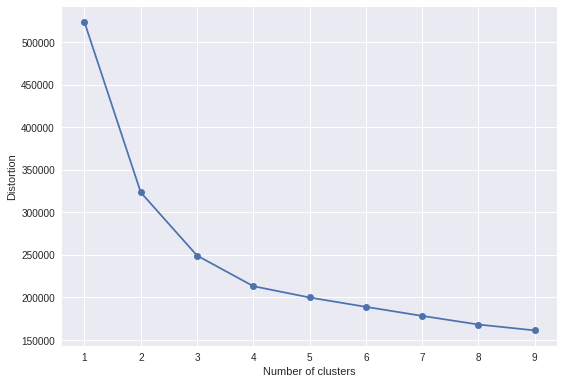

In [36]:
# 如果選取k越大 SSE必然越小
# 但分太多類別也沒有意義
# 這邊藉由SSE 的變化來選擇要分幾類
distortions = []
sup = 10
for i in range(1, sup):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, sup), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()